In [5]:
from src.dataset import MusicImageDataset
from src.diffusion_model import *
from src.utils import postprocess_image, embed_audio
import audio2numpy as a2n
import cv2
from tqdm import tqdm
import wav2clip as w2c
import numpy as np


import warnings
warnings.filterwarnings("ignore")

In [5]:
import pandas as pd

def preprocess_dataframe(dataframe):
    dataframe = dataframe[0].str.split(' ', expand=True)
    dataframe.columns = ['music_id', 'image_id', 'matching']
    dataframe['matching'] = dataframe['matching'].astype(float)
    dataframe = dataframe.where(dataframe['matching'] > 0.5).dropna()
    dataframe = dataframe.where(dataframe['image_id'].str.contains('COCO')).dropna()
    dataframe = dataframe.reset_index(drop=True)
    return dataframe

train_data = preprocess_dataframe(pd.read_csv('data/data/train_matching.txt', sep='\t', header=None))
val_data = preprocess_dataframe(pd.read_csv('data/data/val_matching.txt', sep='\t', header=None))
test_data = preprocess_dataframe(pd.read_csv('data/data/test_matching.txt', sep='\t', header=None))

print(f'Train data: {len(train_data)}\nValidation data: {len(val_data)}\nTest data: {len(test_data)}')

Train data: 29696
Validation data: 2273
Test data: 7249


Similarity: 0.6902185746943501


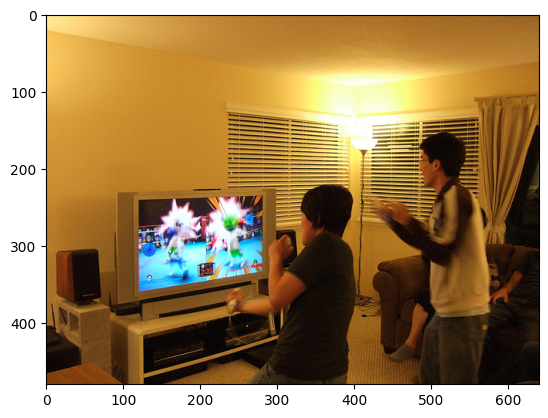

In [7]:
import IPython.display as ipd
import matplotlib.pyplot as plt

def show_music_image(index):
    music_id = train_data.iloc[index]['music_id']
    image_id = train_data.iloc[index]['image_id']
    music_path = 'data/data/music/' + music_id + '.wav'
    image_path = 'data/data/images/' + image_id + '.jpg'

    music = ipd.Audio(music_path)
    image = plt.imread(image_path) 

    print(f'Similarity: {train_data.iloc[index]["matching"]}')
    ipd.display(music)
    plt.imshow(image)

index = np.random.randint(0, len(train_data))
show_music_image(index)

In [8]:
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset

BATCH_SIZE = 32

train_dataset = MusicImageDataset(train_data)
val_dataset = MusicImageDataset(val_data)
test_dataset = MusicImageDataset(test_data)

combined_dataset = ConcatDataset([train_dataset, val_dataset, test_dataset])

train_loader = DataLoader(combined_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

Loading data: 100%|██████████| 7249/7249 [02:44<00:00, 44.17it/s]


Testing:

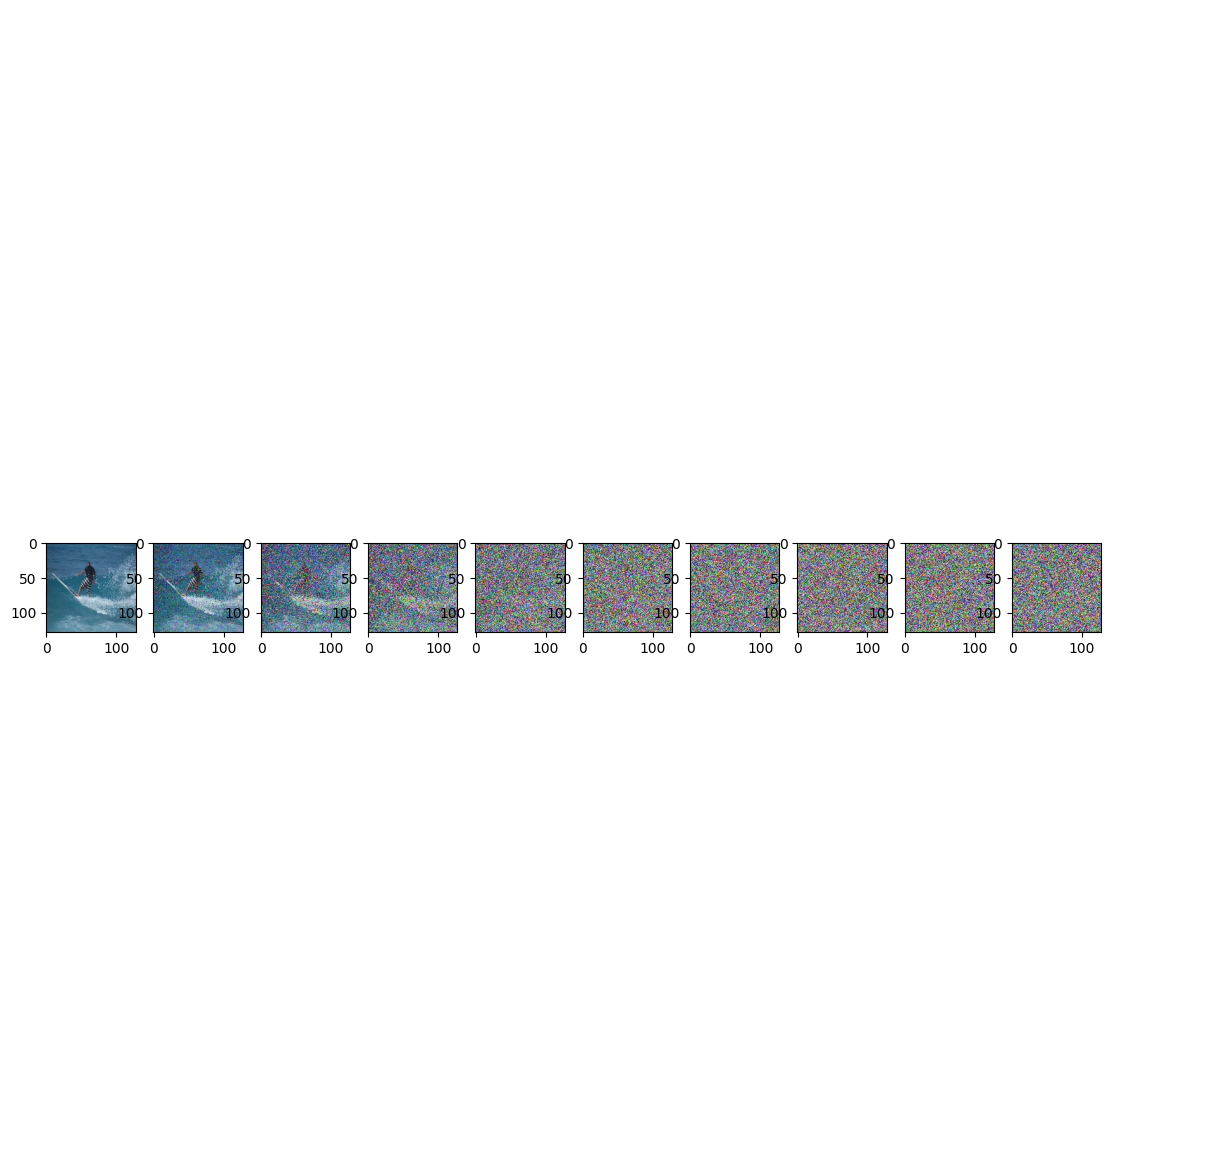

In [11]:
image = next(iter(train_loader))[1]

a = torch.randn_like(image)
plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(T / num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images + 1, int(idx / stepsize) + 1)
    img, noise = forward_diffusion_sample(image[0], t)
    plt.imshow(postprocess_image(img))
plt.show()

## Training

In [6]:
model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  62455299


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (music_embedding): Linear(in_features=512, out_features=32, bias=True)
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128

Epoch 0 | Loss: 0.8115395903587341 


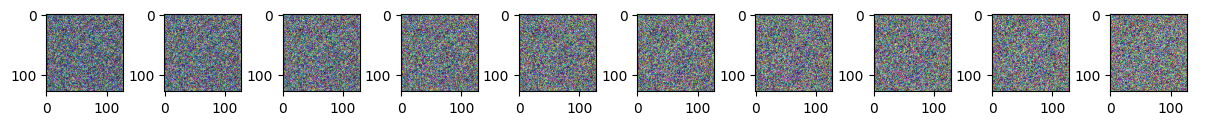

Epoch 5 | Loss: 0.15362665057182312 


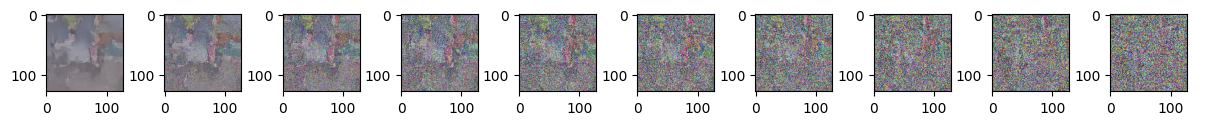

Epoch 10 | Loss: 0.1747112274169922 


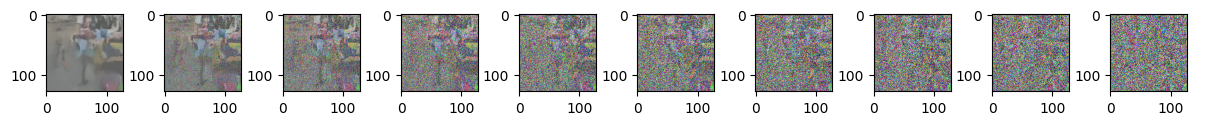

Epoch 15 | Loss: 0.16816380620002747 


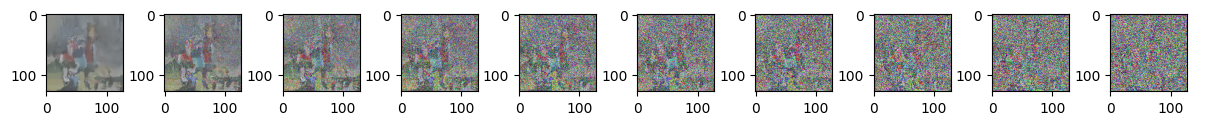

Epoch 20 | Loss: 0.1394917070865631 


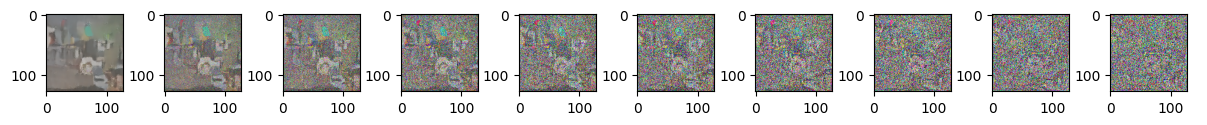

Epoch 25 | Loss: 0.13719379901885986 


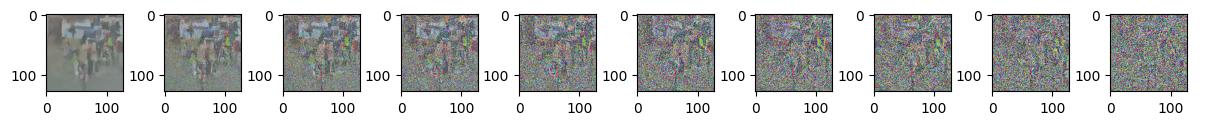

Epoch 30 | Loss: 0.15050087869167328 


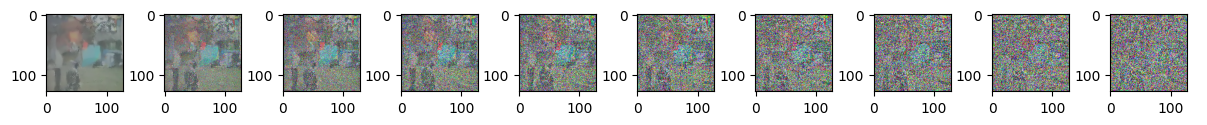

Epoch 35 | Loss: 0.15609478950500488 


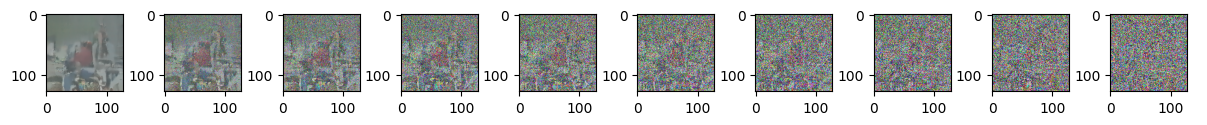

Epoch 40 | Loss: 0.17646315693855286 


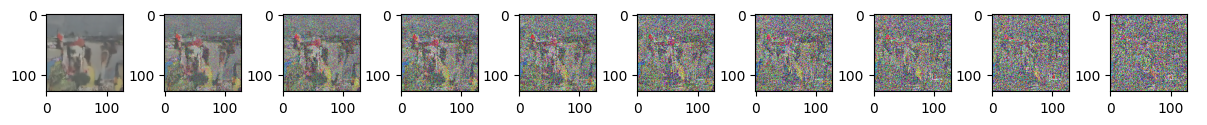

Epoch 45 | Loss: 0.11801408231258392 


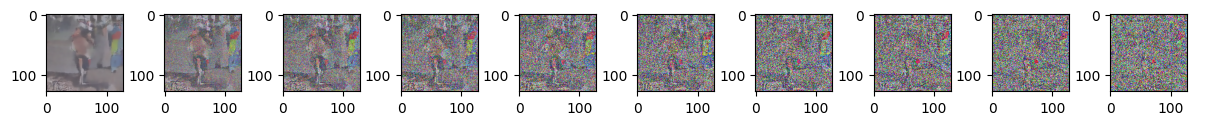

Epoch 50 | Loss: 0.13682478666305542 


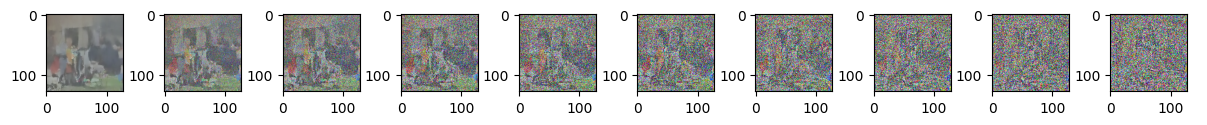

Epoch 55 | Loss: 0.15030254423618317 


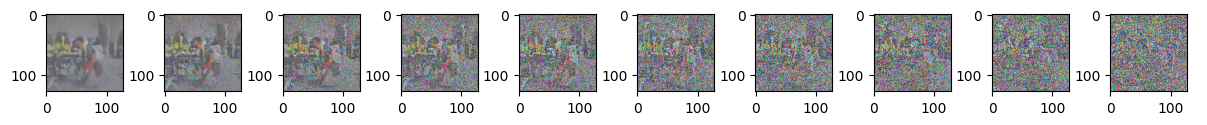

Epoch 60 | Loss: 0.13655522465705872 


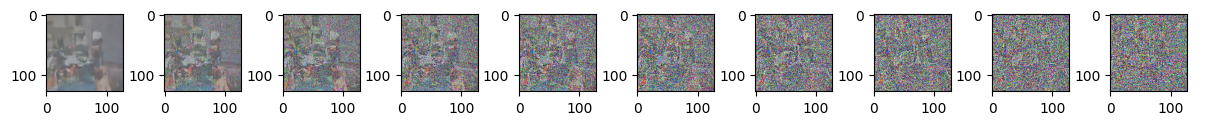

Epoch 65 | Loss: 0.13541746139526367 


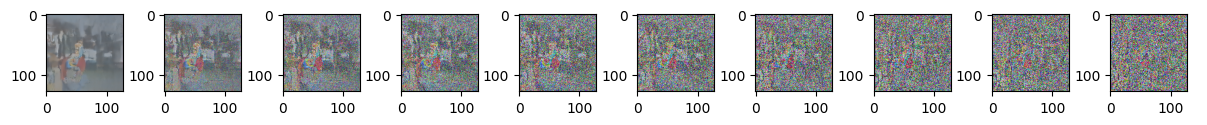

Epoch 70 | Loss: 0.15163449943065643 


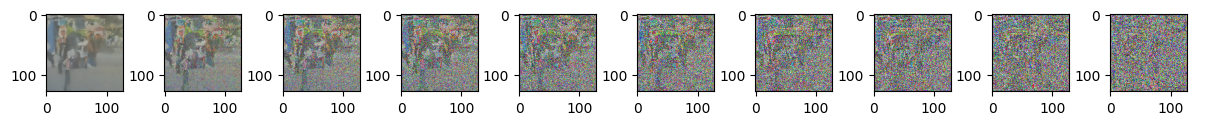

Epoch 75 | Loss: 0.168534517288208 


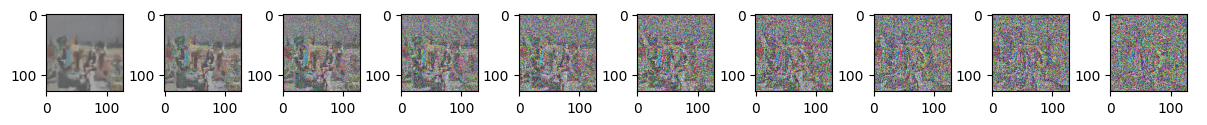

Epoch 80 | Loss: 0.16608783602714539 


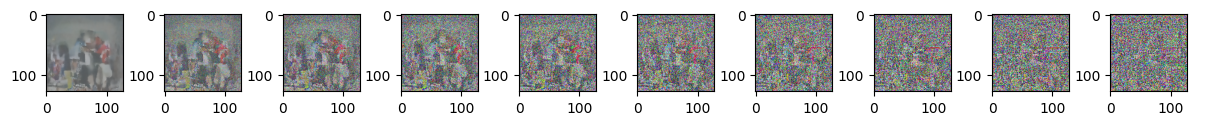

Epoch 85 | Loss: 0.16125009953975677 


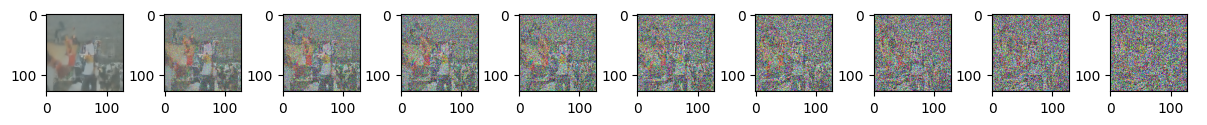

Epoch 90 | Loss: 0.1875651776790619 


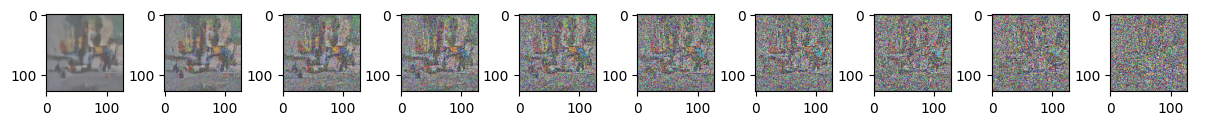

Epoch 95 | Loss: 0.13636396825313568 


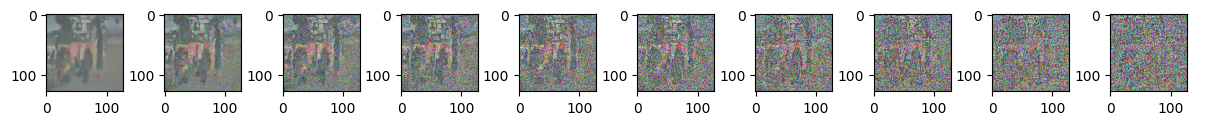

In [15]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 100

for epoch in range(epochs):
    for step, batch in enumerate(train_loader):
      music, image = batch
      music = music.to(device)
      optimizer.zero_grad()
      t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
      loss = get_loss(model, image, t, music, device)
      loss.backward()
      optimizer.step()

      if epoch % 5 == 0 and step == 0:
        print(f"Epoch {epoch} | Loss: {loss.item()} ")
        sample_plot_image(music[0], device)

In [16]:
torch.save(model.state_dict(), 'diffusion_model_100.pth')

In [19]:
model = SimpleUnet()
model.to(device)
model.load_state_dict(torch.load('diffusion_model_100.pth'))

<All keys matched successfully>

In [22]:
test_audio_path = 'data/music/2-1.wav'
w2c_model = w2c.get_model() 
audio, sr = a2n.audio_from_file(test_audio_path)
audio_embedding = w2c.embed_audio(audio, w2c_model)
test_music = torch.tensor(np.squeeze(audio_embedding)).to(device)

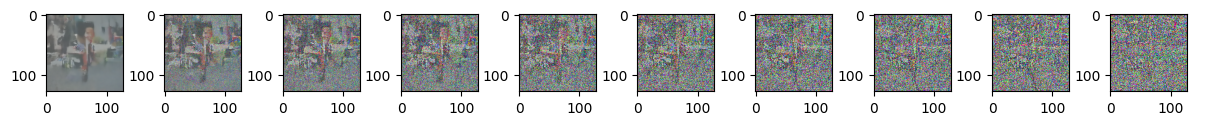

In [27]:
sample_plot_image(test_music, device)